In [2]:
import numpy as np
import pandas as pd
import scipy.io
import warnings
from typing import Dict, Tuple, Any, Optional, List
import logging
from scipy import signal

# Set up logging with more detail
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

class IMUDataProcessor:
    """
    Handles processing of IMU data specific to right-arm worn sensors.
    Combines functionality from both original files into a single, coherent class.
    """
    
    EXPECTED_SAMPLE_RATE = 50  # Hz
    DEFAULT_EXCLUDED_ACTIVITIES = [
        'Device on Table',
        'Non-Exercise',
        'Tap Left Device',
        'Tap Right Device',
        'Arm Band Adjustment',
        'Initial Activity',
        'Invalid',
        'Note',
        'Unlisted Exercise'
    ]
    
    @staticmethod
    def safe_extract_value(array_like, dtype=None):
        """
        Safely extract a scalar value from a numpy array.
        """
        try:
            if hasattr(array_like, 'item'):
                value = array_like.item()
            else:
                value = array_like
                
            if dtype is not None:
                value = dtype(value)
            return value
        except Exception as e:
            logger.error(f"Error extracting value: {str(e)}")
            return None

    @staticmethod
    def process_imu_data(instance: np.ndarray) -> Dict[str, np.ndarray]:
        """
        Process IMU data from the structured array format.
        """
        try:
            # Extract the IMU data fields directly from instance
            imu_struct = instance['data'][0,0][0]
            
            return {
                'accelerometer': imu_struct['accelDataMatrix'][0],
                'gyroscope': imu_struct['gyroDataMatrix'][0],
                'slave_accelerometer': imu_struct['slaveAccelDataMatrix'][0],
                'slave_gyroscope': imu_struct['slaveGyroDataMatrix'][0]
            }
        except Exception as e:
            logger.error(f"Error processing IMU data: {str(e)}")
            return None

class MatlabDataProcessor:
    """
    A unified class to handle loading, processing, and analyzing MATLAB exercise data.
    """
    
    def __init__(self, file_path: str):
        self.file_path = file_path
        self.mat_contents = None
        self.imu_processor = IMUDataProcessor()
        self.activities = None
        self.processed_df = None
    
    def load_file(self) -> None:
        """
        Load the MATLAB file using scipy.io
        """
        try:
            self.mat_contents = scipy.io.loadmat(self.file_path)
            logger.info("File loaded successfully")
            
            # Load activities list if available
            if 'exerciseConstants' in self.mat_contents:
                self.activities = [act[0] for act in self.mat_contents['exerciseConstants'][0,0]['activities'][0]]
                logger.info(f"Loaded {len(self.activities)} activities")
            else:
                logger.warning("No exercise constants found in file")
            
        except Exception as e:
            logger.error(f"Error loading file: {str(e)}")
            raise

    def process_instance(self, instance: np.ndarray, row: int, col: int) -> Optional[Dict[str, Any]]:
        """
        Process a single exercise instance from the subject_data array.
        """
        try:
            # Skip empty instances
            if instance.size == 0:
                return None
            
            logger.debug(f"Processing instance at [{row},{col}]")
            
            # Basic instance information
            instance_data = {
                'matrix_row': row,
                'matrix_col': col
            }
            
            # Try to extract subject ID - field name might vary
            for field in ['subjectID', 'subjectIndex']:
                if field in instance.dtype.names:
                    subject_id = self.imu_processor.safe_extract_value(instance[field][0,0], dtype=int)
                    if subject_id is not None:
                        instance_data['subject_id'] = subject_id
                        break
            
            # Extract activity name
            if 'activityName' in instance.dtype.names:
                activity_name = self.imu_processor.safe_extract_value(instance['activityName'][0,0], dtype=str)
                if activity_name:
                    instance_data['activity_name'] = activity_name
            
            # Optional fields
            if 'activityReps' in instance.dtype.names and instance['activityReps'][0,0].size > 0:
                instance_data['activity_reps'] = self.imu_processor.safe_extract_value(instance['activityReps'][0,0], dtype=int)
            
            if 'activityVideoStartTimeSeconds' in instance.dtype.names and instance['activityVideoStartTimeSeconds'][0,0].size > 0:
                instance_data['start_time'] = self.imu_processor.safe_extract_value(instance['activityVideoStartTimeSeconds'][0,0], dtype=float)
            
            # Process IMU data
            imu_data = self.imu_processor.process_imu_data(instance)
            if imu_data:
                instance_data['imu_data'] = imu_data
                logger.debug(f"Successfully processed IMU data for instance [{row},{col}]")
            else:
                logger.warning(f"No IMU data processed for instance [{row},{col}]")
                return None
            
            return instance_data
            
        except Exception as e:
            logger.error(f"Error processing instance [{row},{col}]: {str(e)}")
            return None

    def convert_to_timeseries(self, instance_data: Dict[str, Any]) -> Optional[pd.DataFrame]:
        """
        Convert a processed instance into a time-series DataFrame.
        """
        try:
            imu_data = instance_data['imu_data']
            accel_data = imu_data['accelerometer']
            gyro_data = imu_data['gyroscope']
            
            n_samples = accel_data.shape[0]
            
            df_data = {
                'timestamp': accel_data[:, 0].astype(float),
                'acc_X': accel_data[:, 1].astype(float),
                'acc_Y': accel_data[:, 2].astype(float),
                'acc_Z': accel_data[:, 3].astype(float),
                'gyr_X': gyro_data[:, 1].astype(float),
                'gyr_Y': gyro_data[:, 2].astype(float),
                'gyr_Z': gyro_data[:, 3].astype(float),
                'matrix_row': [instance_data['matrix_row']] * n_samples,
                'matrix_col': [instance_data['matrix_col']] * n_samples
            }
            
            # Add required metadata if available
            for field in ['activity_name', 'subject_id']:
                if field in instance_data:
                    df_data[field] = [instance_data[field]] * n_samples
            
            # Add optional metadata
            for field in ['activity_reps', 'start_time']:
                if field in instance_data:
                    df_data[field] = [instance_data[field]] * n_samples
            
            return pd.DataFrame(df_data)
            
        except Exception as e:
            logger.error(f"Error converting to timeseries: {str(e)}")
            return None

    def process_all_data(self, convert_to_df: bool = True) -> Any:
        """
        Process all valid exercise instances in the subject_data array.
        """
        try:
            if 'subject_data' not in self.mat_contents:
                raise ValueError("No subject_data found in MATLAB file")
                
            subject_data = self.mat_contents['subject_data']
            logger.info(f"Processing data matrix of shape {subject_data.shape}")
            
            processed_instances = []
            all_dfs = []
            
            total_instances = 0
            valid_instances = 0
            
            for i in range(subject_data.shape[0]):
                for j in range(subject_data.shape[1]):
                    cell_data = subject_data[i, j]
                    total_instances += 1
                    
                    if cell_data.size > 0:
                        instance = self.process_instance(cell_data, i, j)
                        if instance:
                            valid_instances += 1
                            
                            if convert_to_df:
                                df = self.convert_to_timeseries(instance)
                                if df is not None:
                                    all_dfs.append(df)
                            else:
                                processed_instances.append(instance)
            
            logger.info(f"Processed {valid_instances} valid instances out of {total_instances} total cells")
            
            if convert_to_df:
                if not all_dfs:
                    logger.error("No valid DataFrames were created during processing")
                    raise ValueError("No valid data was processed")
                    
                final_df = pd.concat(all_dfs, ignore_index=True)
                final_df = final_df.sort_values(['subject_id', 'timestamp']).reset_index(drop=True)
                self.processed_df = final_df
                logger.info(f"Created final DataFrame with {len(final_df)} rows")
                return final_df
            else:
                return processed_instances
                
        except Exception as e:
            logger.error(f"Error processing data: {str(e)}")
            raise

    def get_dataset_summary(self) -> Dict[str, Any]:
        """
        Generate comprehensive summary statistics for the processed dataset.
        """
        if self.processed_df is None:
            raise ValueError("No processed data available. Run process_all_data first.")
            
        df = self.processed_df
        summary = {
            'total_samples': len(df),
            'total_subjects': df['subject_id'].nunique(),
            'total_activities': df['activity_name'].nunique(),
            'samples_per_subject': df.groupby('subject_id').size().agg(['min', 'max', 'mean', 'median']).to_dict(),
            'activities_per_subject': df.groupby('subject_id')['activity_name'].nunique().agg(['min', 'max', 'mean', 'median']).to_dict(),
            'top_activities': df.groupby('activity_name').size().sort_values(ascending=False).head(10).to_dict()
        }
        
        if 'activity_reps' in df.columns:
            summary['reps_by_activity'] = df.groupby('activity_name')['activity_reps'].first().to_dict()
        
        return summary

    def filter_activities(self, exclude_activities: List[str] = None) -> pd.DataFrame:
        """
        Filter out specified activities from the processed DataFrame.
        """
        if self.processed_df is None:
            raise ValueError("No processed data available. Run process_all_data first.")
            
        if exclude_activities is None:
            exclude_activities = self.imu_processor.DEFAULT_EXCLUDED_ACTIVITIES
        
        filtered_df = self.processed_df[~self.processed_df['activity_name'].isin(exclude_activities)].reset_index(drop=True)
        return filtered_df

def process_matlab_data(file_path: str, convert_to_df: bool = True) -> Tuple[Any, List[str]]:
    """
    Convenience function to load and process the MATLAB file.
    """
    processor = MatlabDataProcessor(file_path)
    
    try:
        processor.load_file()
        processed_data = processor.process_all_data(convert_to_df=convert_to_df)
        return processed_data, processor.activities
    
    except Exception as e:
        logger.error(f"Error in data loading and processing: {str(e)}")
        raise

C:\Users\bellj\AppData\Local\Temp\ipykernel_79012\1182485594.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
processor = MatlabDataProcessor('../../exercise_data.50.0000_singleonly.mat')
processor.load_file()


2025-02-12 19:27:39,756 - INFO - File loaded successfully
2025-02-12 19:27:39,764 - INFO - Loaded 75 activities


In [4]:
data_df = processor.process_all_data(convert_to_df=True)
data_df.head()

2025-02-12 19:27:39,786 - INFO - Processing data matrix of shape (94, 75)
2025-02-12 19:27:50,998 - INFO - Processed 2056 valid instances out of 7050 total cells
2025-02-12 19:28:04,635 - INFO - Created final DataFrame with 7751906 rows


,timestamp,acc_X,acc_Y,acc_Z,gyr_X,gyr_Y,gyr_Z,matrix_row,matrix_col,activity_name,subject_id,activity_reps,start_time
0,52.399884,-0.678057,-0.525088,0.661963,-236.269299,-84.986143,77.036312,0,37,Pushup (knee or foot variation),3,15,52.398
1,52.419884,-0.761620,-0.486444,0.510914,-60.762158,-80.643264,9.613385,0,37,Pushup (knee or foot variation),3,15,52.398
2,52.439884,-0.830902,0.344620,0.452458,-2.964748,-63.789937,-49.127510,0,37,Pushup (knee or foot variation),3,15,52.398
3,52.459884,-0.765491,0.053850,0.697407,-46.231902,-48.940760,-68.153642,0,37,Pushup (knee or foot variation),3,15,52.398
4,52.479884,-0.737729,-0.335286,0.746702,-26.699921,-8.786237,-78.926749,0,37,Pushup (knee or foot variation),3,15,52.398


In [5]:
summary = processor.get_dataset_summary()
summary

{'total_samples': 7751906,
 'total_subjects': 94,
 'total_activities': 73,
 'samples_per_subject': {'min': 40212.0,
  'max': 265894.0,
  'mean': 82467.08510638298,
  'median': 68571.0},
 'activities_per_subject': {'min': 10.0,
  'max': 59.0,
  'mean': 21.872340425531913,
  'median': 18.0},
 'top_activities': {'Device on Table': 1301735,
  'Walk': 608204,
  'Static stretch': 451196,
  'Static Stretch (at your own pace)': 313323,
  'Running (treadmill)': 291569,
  'Dynamic Stretch (at your own pace)': 284271,
  'Elliptical machine': 275296,
  'Rowing machine': 267743,
  'Plank': 139039,
  'Lunge (alternating both legs, weight optional)': 131904},
 'reps_by_activity': {'Alternating Dumbbell Curl': 20,
  'Arm Band Adjustment': -1,
  'Arm straight up': -1,
  'Band Pull-Down Row': 20,
  'Bicep Curl': 26,
  'Biceps Curl (band)': 20,
  'Box Jump (on bench)': 15,
  'Burpee': 11,
  'Butterfly Sit-up': 20,
  'Chest Press (rack)': 20,
  'Crunch': 20,
  'Device on Table': -1,
  'Dip': 15,
  'Dumbbe

In [6]:
filtered_df = processor.filter_activities()
filtered_df.head()

,timestamp,acc_X,acc_Y,acc_Z,gyr_X,gyr_Y,gyr_Z,matrix_row,matrix_col,activity_name,subject_id,activity_reps,start_time
0,52.399884,-0.678057,-0.525088,0.661963,-236.269299,-84.986143,77.036312,0,37,Pushup (knee or foot variation),3,15,52.398
1,52.419884,-0.761620,-0.486444,0.510914,-60.762158,-80.643264,9.613385,0,37,Pushup (knee or foot variation),3,15,52.398
2,52.439884,-0.830902,0.344620,0.452458,-2.964748,-63.789937,-49.127510,0,37,Pushup (knee or foot variation),3,15,52.398
3,52.459884,-0.765491,0.053850,0.697407,-46.231902,-48.940760,-68.153642,0,37,Pushup (knee or foot variation),3,15,52.398
4,52.479884,-0.737729,-0.335286,0.746702,-26.699921,-8.786237,-78.926749,0,37,Pushup (knee or foot variation),3,15,52.398


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Union, List, Dict, Tuple
import logging

logger = logging.getLogger(__name__)

class IMUVisualizer:
    """
    Handles visualization of IMU sensor data with enhanced features.
    """
    
    def __init__(self, df: pd.DataFrame):
        """
        Initialize the visualizer with a DataFrame.
        
        Args:
            df: DataFrame containing IMU data with required columns
        """
        self.df = df.copy()  # Create a copy to avoid modifying original data
        self._validate_dataframe()
        self.default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
        
    def _validate_dataframe(self) -> None:
        """Validate that the DataFrame has all required columns."""
        required_columns = [
            'timestamp', 'activity_name',
            'acc_X', 'acc_Y', 'acc_Z',
            'gyr_X', 'gyr_Y', 'gyr_Z'
        ]
        
        missing_cols = [col for col in required_columns if col not in self.df.columns]
        if missing_cols:
            raise ValueError(f"DataFrame missing required columns: {missing_cols}")

    def get_activity_segments(self, activity: str) -> List[pd.DataFrame]:
        """
        Split activity data into separate continuous segments.
        
        Args:
            activity: Name of the activity to segment
            
        Returns:
            List of DataFrames, each containing a continuous segment
        """
        activity_data = self.df[self.df['activity_name'] == activity].copy()
        
        if activity_data.empty:
            logger.warning(f"No data found for activity: {activity}")
            return []
        
        # Sort by timestamp to ensure proper segmentation
        activity_data = activity_data.sort_values('timestamp')
        
        # Identify breaks between segments (gaps > 0.1 seconds)
        activity_data['time_diff'] = activity_data['timestamp'].diff()
        segment_breaks = activity_data[activity_data['time_diff'] > 0.1].index
        
        # Split into segments
        segments = []
        if len(segment_breaks) == 0:
            segments = [activity_data]
        else:
            indices = np.split(activity_data.index, segment_breaks)
            segments = [activity_data.loc[idx].copy() for idx in indices if len(idx) > 0]
        
        # Add relative timestamps to each segment
        for segment in segments:
            if not segment.empty:
                segment['relative_time'] = segment['timestamp'] - segment['timestamp'].iloc[0]
            
        return [seg for seg in segments if len(seg) > 0]

    def plot_imu_data(self,
                     activity: str,
                     sensor_type: str = 'both',
                     time_window: Optional[float] = None,
                     instance_index: int = 0,
                     figsize: tuple = (15, 8),
                     show_statistics: bool = True) -> Optional[Tuple[plt.Figure, Union[plt.Axes, Tuple[plt.Axes, plt.Axes]]]]:
        """
        Plot IMU data for a specific activity with enhanced features.
        
        Args:
            activity: Name of the activity to plot
            sensor_type: 'acc' for accelerometer, 'gyr' for gyroscope, or 'both' for both
            time_window: Number of seconds to plot (None for entire activity)
            instance_index: Which instance of the activity to plot
            figsize: Figure size for the plot
            show_statistics: Whether to show summary statistics in the plot
            
        Returns:
            Tuple of (figure, axes) if successful, None otherwise
        """
        segments = self.get_activity_segments(activity)
        
        if not segments:
            logger.warning(f"No segments found for activity: {activity}")
            return None
            
        if instance_index >= len(segments):
            logger.warning(f"Instance index {instance_index} out of range. Maximum available: {len(segments)-1}")
            return None
        
        # Get data for the specified instance
        instance_data = segments[instance_index]
        
        # Ensure data is sorted by time
        instance_data = instance_data.sort_values('relative_time')
        
        # Apply time window if specified
        if time_window is not None:
            instance_data = instance_data[instance_data['relative_time'] <= time_window].copy()
        
        # Create the plot
        if sensor_type == 'both':
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
            axes = (ax1, ax2)
        else:
            fig, ax1 = plt.subplots(figsize=figsize)
            axes = ax1
        
        # Plot accelerometer data
        if sensor_type in ['acc', 'both']:
            self._plot_sensor_data(ax1, instance_data, 'acc', show_statistics)
        
        # Plot gyroscope data
        if sensor_type in ['gyr', 'both']:
            ax = ax2 if sensor_type == 'both' else ax1
            self._plot_sensor_data(ax, instance_data, 'gyr', show_statistics)
        
        plt.tight_layout()
        return fig, axes

    def _plot_sensor_data(self, ax: plt.Axes, data: pd.DataFrame, 
                         sensor_type: str, show_statistics: bool) -> None:
        """Helper method to plot sensor data with statistics."""
        sensor_map = {
            'acc': ('Accelerometer', 'Acceleration (m/s²)', ['acc_X', 'acc_Y', 'acc_Z']),
            'gyr': ('Gyroscope', 'Angular Velocity (rad/s)', ['gyr_X', 'gyr_Y', 'gyr_Z'])
        }
        
        title, ylabel, columns = sensor_map[sensor_type]
        activity = data['activity_name'].iloc[0]
        
        # Plot the data
        for col, color in zip(columns, self.default_colors):
            ax.plot(data['relative_time'], data[col], 
                   label=col.split('_')[1], color=color)
        
        # Add statistics if requested
        if show_statistics:
            stats_text = self._generate_statistics(data[columns])
            ax.text(0.02, 0.98, stats_text,
                   transform=ax.transAxes,
                   verticalalignment='top',
                   fontsize=8,
                   bbox=dict(facecolor='white', alpha=0.8))
        
        ax.set_title(f'{title} Data - {activity}')
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Ensure axis limits are appropriate
        ax.set_xlim(data['relative_time'].min(), data['relative_time'].max())
        y_range = max(abs(data[columns].min().min()), abs(data[columns].max().max()))
        ax.set_ylim(-y_range * 1.1, y_range * 1.1)

    def _generate_statistics(self, data: pd.DataFrame) -> str:
        """Generate summary statistics text."""
        stats = []
        for col in data.columns:
            axis = col.split('_')[1]
            stats.extend([
                f"{axis}-axis statistics:",
                f"  Mean: {data[col].mean():.2f}",
                f"  Std: {data[col].std():.2f}",
                f"  Max: {data[col].max():.2f}",
                f"  Min: {data[col].min():.2f}"
            ])
        return '\n'.join(stats)

    def get_activity_summary(self, activity: str = None) -> pd.DataFrame:
        """
        Get summary statistics for one or all activities.
        
        Args:
            activity: Specific activity to summarize, or None for all activities
            
        Returns:
            DataFrame containing activity statistics
        """
        if activity:
            data = self.df[self.df['activity_name'] == activity]
        else:
            data = self.df
            
        summaries = []
        for name, group in data.groupby('activity_name'):
            segments = self.get_activity_segments(name)
            
            # Skip if no valid segments
            if not segments:
                continue
                
            summary = {
                'activity_name': name,
                'total_instances': len(segments),
                'total_samples': len(group),
                'avg_duration': np.mean([seg['relative_time'].max() for seg in segments]),
                'min_duration': np.min([seg['relative_time'].max() for seg in segments]),
                'max_duration': np.max([seg['relative_time'].max() for seg in segments])
            }
            
            # Add sensor statistics
            for sensor in ['acc', 'gyr']:
                for axis in ['X', 'Y', 'Z']:
                    col = f'{sensor}_{axis}'
                    summary.update({
                        f'{col}_mean': group[col].mean(),
                        f'{col}_std': group[col].std(),
                        f'{col}_max': group[col].max(),
                        f'{col}_min': group[col].min()
                    })
            
            summaries.append(summary)
            
        return pd.DataFrame(summaries)

    def list_available_activities(self) -> pd.DataFrame:
        """
        List all available activities and their instance counts.
        
        Returns:
            DataFrame containing activity information
        """
        activities = []
        for activity in self.df['activity_name'].unique():
            segments = self.get_activity_segments(activity)
            if segments:  # Only include activities with valid segments
                durations = [seg['relative_time'].max() for seg in segments]
                activities.append({
                    'activity': activity,
                    'instances': len(segments),
                    'total_samples': len(self.df[self.df['activity_name'] == activity]),
                    'avg_duration': np.mean(durations),
                    'min_duration': np.min(durations),
                    'max_duration': np.max(durations)
                })
        
        return pd.DataFrame(activities).set_index('activity')



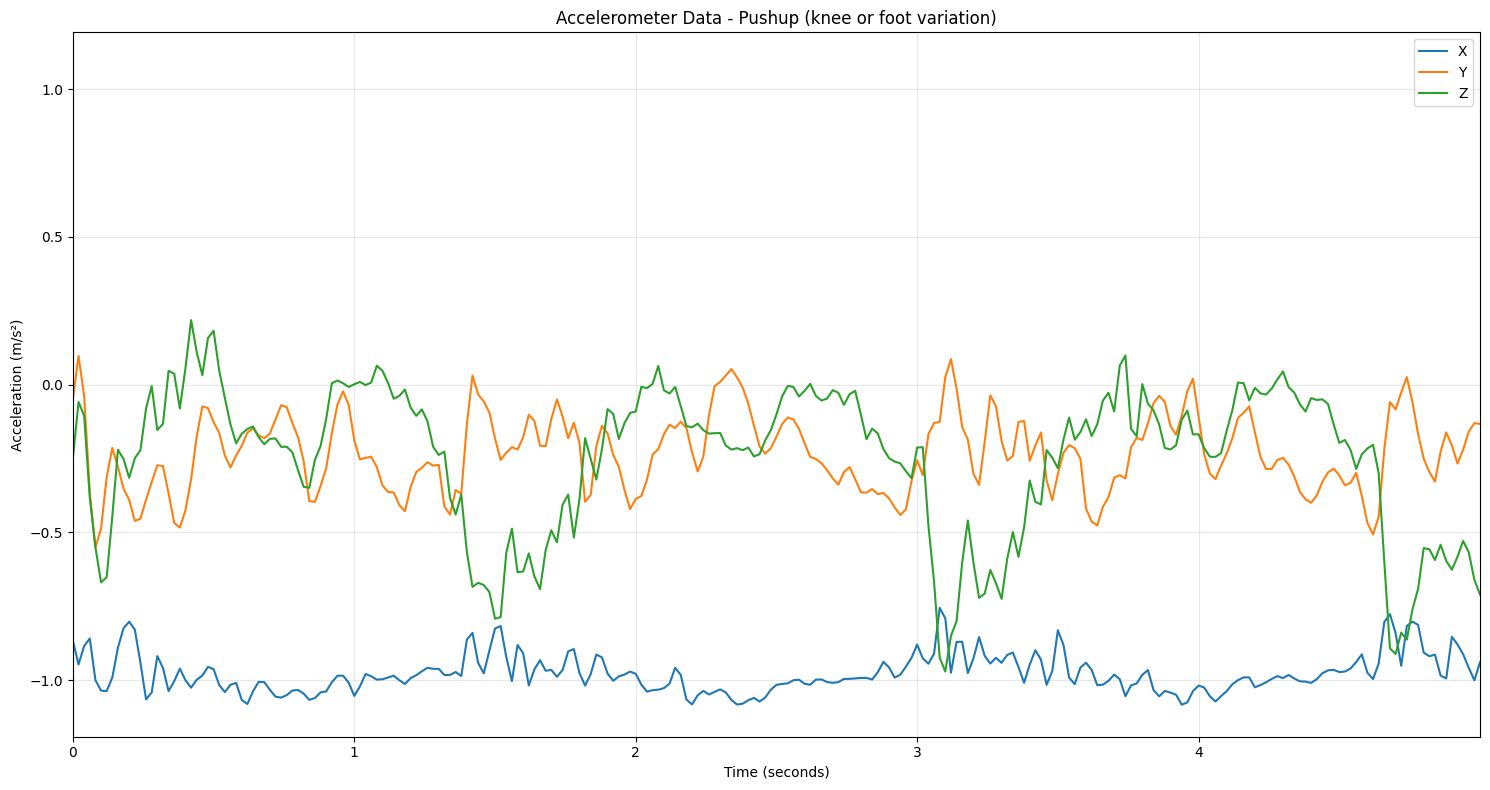

In [8]:
# Initialize the visualizer
visualizer = IMUVisualizer(filtered_df)


fig, axes = visualizer.plot_imu_data(
    activity='Pushup (knee or foot variation)',
    sensor_type='acc',
    time_window=5,
    show_statistics=False
)

## This takes a while to run ~90 seconds

In [9]:
# List available activities
activities = visualizer.list_available_activities()
print("Available activities:")
print(activities)


Available activities:
                                                   instances  total_samples  \
activity                                                                      
Pushup (knee or foot variation)                            1          61167   
Kettlebell Swing                                           1          66294   
Squat (arms in front of body, parallel to ground)          1         116623   
Russian Twist                                              1          92907   
Overhead Triceps Extension                                 1          84893   
...                                                      ...            ...   
Alternating Dumbbell Curl                                  1           3526   
Triceps extension (lying down) (right arm)                 1           1422   
Triceps extension (lying down) (left arm)                  1           1491   
Box Jump (on bench)                                        1           8748   
Lawnmower (label spans both ar

In [10]:
activities.index.to_list()

['Pushup (knee or foot variation)',
 'Kettlebell Swing',
 'Squat (arms in front of body, parallel to ground)',
 'Russian Twist',
 'Overhead Triceps Extension',
 'Jumping Jacks',
 'Triceps extension (lying down)',
 'Sit-up (hands positioned behind head)',
 'Plank',
 'Wall Squat',
 'Dip',
 'Biceps Curl (band)',
 'Lateral Raise',
 'Elliptical machine',
 'Static Stretch (at your own pace)',
 'Squat Jump',
 'Repetitive Stretching',
 'Sit-ups',
 'Shoulder Press (dumbbell)',
 'Squat Rack Shoulder Press',
 'Band Pull-Down Row',
 'V-up',
 'Dumbbell Deadlift Row',
 'Crunch',
 'Dumbbell Row (knee on bench) (label spans both arms)',
 'Chest Press (rack)',
 'Lunge (alternating both legs, weight optional)',
 'Side Plank Right side',
 'Squat (kettlebell / goblet)',
 'Side Plank Left side',
 'Two-arm Dumbbell Curl (both arms, not alternating)',
 'Burpee',
 'Bicep Curl',
 'Triceps Kickback (knee on bench) (label spans both arms)',
 'Seated Back Fly',
 'Rowing machine',
 'Butterfly Sit-up',
 'Static str

In [11]:
import pandas as pd

# Mapping of RECOFIT exercises to MM Fit names
exercise_mapping = {
    # ✅ Direct Matches
    'Pushups': 'Pushups',
    'Jumping Jacks': 'Jumping Jacks',
    'Sit-ups': 'Situps',
    'Bicep Curl': 'Bicep Curls',
    'Lateral Raise': 'Lateral Shoulder Raises',

    # 🔸 Partial Matches (Closest Equivalent)
    'Squat': 'Squats',
    'Squat Jump': 'Squats',
    'Wall Squat': 'Squats',
    'Dumbbell Squat (hands at side)': 'Squats',
    'Squat (arms in front of body, parallel to ground)': 'Squats',
    'Squat (hands behind head)': 'Squats',
    'Squat (kettlebell / goblet)': 'Squats',

    'Pushup (knee or foot variation)': 'Pushups',

    'Shoulder Press (dumbbell)': 'Dumbbell Shoulder Press',
    'Squat Rack Shoulder Press': 'Dumbbell Shoulder Press',

    'Lunge (alternating both legs, weight optional)': 'Lunges',
    'Walking lunge': 'Lunges',

    'Dumbbell Row (knee on bench) (label spans both arms)': 'Dumbbell Rows',
    'Dumbbell Row (knee on bench) (left arm)': 'Dumbbell Rows',
    'Dumbbell Row (knee on bench) (right arm)': 'Dumbbell Rows',
    'Dumbbell Deadlift Row': 'Dumbbell Rows',

    'Overhead Triceps Extension': 'Tricep Extensions',
    'Triceps extension (lying down)': 'Tricep Extensions',
    'Triceps Kickback (knee on bench) (label spans both arms)': 'Tricep Extensions',
    'Triceps Kickback (knee on bench) (left arm)': 'Tricep Extensions',
    'Triceps Kickback (knee on bench) (right arm)': 'Tricep Extensions',
    'Triceps extension (lying down) (left arm)': 'Tricep Extensions',
    'Triceps extension (lying down) (right arm)': 'Tricep Extensions',

    # ❌ No Direct Match (Keeping As-Is for Now)
    'Non-Exercise': 'Non Exercise',
    'Device on Table': 'Device on Table',
    'Tap Left Device': 'Tap Left Device',
    'Tap Right Device': 'Tap Right Device',
    'Arm Band Adjustment': 'Arm Band Adjustment',
    'Initial Activity': 'Initial Activity',
    'Invalid': 'Invalid',
    'Note': 'Note',
    'Unlisted Exercise': 'Unlisted Exercise'
}

def rename_exercises(df, column_name='activity_name'):
    """
    Returns a new DataFrame with exercise names mapped to MM Fit format
    in camel case with spaces. The original DataFrame remains unchanged.
    """
    def format_camel_case(text):
        """ Convert text to camel case with spaces """
        return ' '.join(word.capitalize() for word in text.split())

    def map_exercise(name):
        """ Map exercise names based on predefined dictionary """
        return exercise_mapping.get(name, format_camel_case(name))

    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Apply renaming function
    df_copy[column_name] = df_copy[column_name].apply(map_exercise)
    
    return df_copy  # Return the modified copy

# Example usage with a sample DataFrame
df_recofit = pd.DataFrame({'activity_name': [
    'Pushups', 'Jumping Jacks', 'Sit-ups', 'Bicep Curl', 'Lateral Raise',
    'Squat', 'Squat Jump', 'Dumbbell Squat (hands at side)', 'Pushup (knee or foot variation)',
    'Shoulder Press (dumbbell)', 'Dumbbell Row (knee on bench) (right arm)',
    'Overhead Triceps Extension', 'Non-Exercise', 'Device on Table'
]})


# Rename exercises in the DataFrame
df_recofit = rename_exercises(filtered_df)

In [17]:
df_recofit[:10]

,timestamp,acc_X,acc_Y,acc_Z,gyr_X,gyr_Y,gyr_Z,matrix_row,matrix_col,activity_name,subject_id,activity_reps,start_time
0,52.399884,-0.678057,-0.525088,0.661963,-236.269299,-84.986143,77.036312,0,37,Pushups,3,15,52.398
1,52.419884,-0.761620,-0.486444,0.510914,-60.762158,-80.643264,9.613385,0,37,Pushups,3,15,52.398
2,52.439884,-0.830902,0.344620,0.452458,-2.964748,-63.789937,-49.127510,0,37,Pushups,3,15,52.398
3,52.459884,-0.765491,0.053850,0.697407,-46.231902,-48.940760,-68.153642,0,37,Pushups,3,15,52.398
4,52.479884,-0.737729,-0.335286,0.746702,-26.699921,-8.786237,-78.926749,0,37,Pushups,3,15,52.398
5,52.499884,-0.792972,-0.073016,0.395227,-9.762046,-2.107296,-64.222731,0,37,Pushups,3,15,52.398
6,52.519884,-0.726873,-0.106127,0.621769,-4.815892,0.865121,-78.049671,0,37,Pushups,3,15,52.398
7,52.539884,-0.849523,-0.185204,0.513555,4.701395,4.710394,-89.248230,0,37,Pushups,3,15,52.398
8,52.559884,-0.771307,-0.363072,0.606765,1.413388,16.768727,-79.306417,0,37,Pushups,3,15,52.398
9,52.579884,-0.858706,-0.159140,0.417540,-18.427509,10.327493,-42.709612,0,37,Pushups,3,15,52.398


In [19]:
df_recofit['matrix_col'].value_counts()

matrix_col
70    608204
57    451196
56    313323
42    291569
18    284271
       ...  
74      3526
65      1491
66      1422
2        221
58        78
Name: count, Length: 66, dtype: int64